In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from pixell import enmap

In [4]:
den, pot, t11, t12, t22 = hp.read_map("../outputs/out_2MASS_XSC_EQ/tidal_sm2.0.fits", field=[0,1,2,3,4])
npix = len(t11)
nside = hp.get_nside(t11)

# generate eigenvectors
array_stack = np.zeros( (npix, 2, 2) ) # long axis is first
array_stack[:,0,0] = t11
array_stack[:,1,0] = -t12
array_stack[:,0,1] = -t12
array_stack[:,1,1] = t22
w,v = np.linalg.eig(a=array_stack)
principal_eig_ind = np.argmax( np.abs(w), axis=1 )
principal_eigenvectors = np.array( [v[i,:,principal_eig_ind[i]] for i in range(npix)] )
principal_eigenvalues = np.array( [w[i,principal_eig_ind[i]] for i in range(npix)] )

# load in galaxy
hdu = fits.open("../data/2MASS_XSC.fits")
galaxy_data = hdu[1].data

# masking and cuts
galaxy_ind = hp.ang2pix( 
    nside=nside, 
    phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )
mask = hp.read_map("../outputs/out_2MASS_XSC_EQ/mask.fits")
ellip = (1-galaxy_data['j_ba'])
cut = np.logical_and(galaxy_data['kcorr_schlegel'] < 13.9, mask[galaxy_ind] > 0.0)
cut = np.logical_and(cut, ellip > 0.5)
galaxy_data = galaxy_data[ cut ]

# get info
amp = 1#(1-galaxy_data['j_5sig_ba'])
phi_x = -amp * np.cos((90-galaxy_data['j_phi']) * np.pi / 180)
phi_y = amp * np.sin((90-galaxy_data['j_phi']) * np.pi / 180)
hp_gal = hp.ang2pix( 
    nside=nside, 
    phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [5]:
th,ph=hp.pix2ang(nside,np.arange(npix))

In [97]:
# hp.mollview(th)

In [8]:
def get_cutout_from_hp(field, kernel_width=0.005 * np.pi / 180.0, 
                       width=np.pi / 8, height=np.pi / 8, 
                       center_phi=np.pi, center_theta=np.pi/2, 
                       xp=100, yp=100, debug=False):
    smoothed_cutout = np.zeros((xp,yp))
    ph_grid = np.zeros((xp,yp))
    th_grid = np.zeros((xp,yp))

    for i in range(xp):
        for j in range(yp):
            ph0 = (center_phi - width/2 + i * width/xp) 
            th0 = (center_theta - height/2 + j * height/xp) 
            ph_grid[i,j] = ph0
            th_grid[i,j] = th0
            smoothed_cutout[i,j] = np.sum( 
                np.exp( -( (th - th0)**2 + (ph - ph0)**2) / (2 * kernel_width) ) * field )

    norm = np.sum( np.exp( -( (th - center_theta)**2 + (ph - center_phi)**2) / (2 * kernel_width) ) * 1 )
    smoothed_cutout /= norm
    
    # hp.mollview( den, rot=(-90,0,0))
    if debug:
        den_copy_highlighted = den.copy()
        region = np.logical_and( 
            np.logical_and( th < center_theta + height/2,  th > center_theta - height/2 ),
            np.logical_and( ph < center_phi + width/2, ph > center_phi - width/2 )
            )
        den_copy_highlighted[~region] *= 0.1
        hp.mollview( den_copy_highlighted, rot=(-180,0,0))
    
    return smoothed_cutout, ph_grid, th_grid

(3.334015203622168, 2.945243112740431)

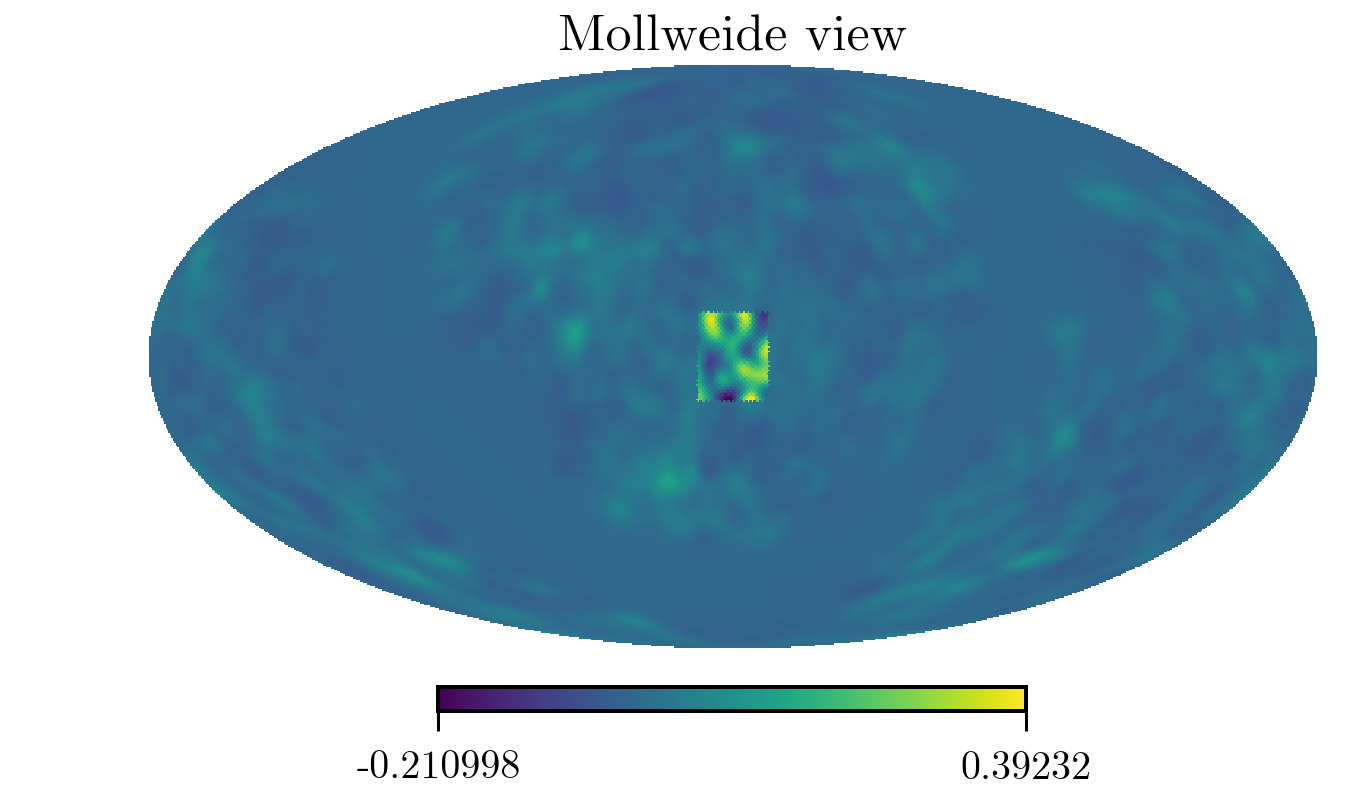

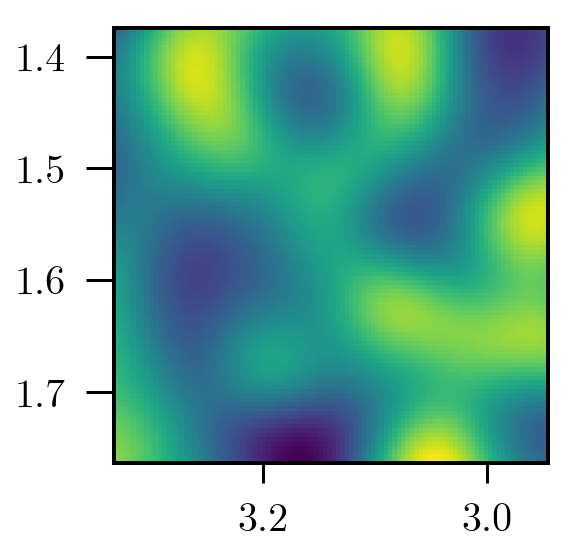

In [9]:
smoothed_cutout, ph_, th_ = get_cutout_from_hp(den, debug=True)
plt.figure()

plt.imshow(smoothed_cutout.T,
          extent=( np.min(ph_), np.max(ph_), np.max(th_), np.min(th_)) )
plt.xlim( np.max(ph_), np.min(ph_) )

# plt.figure()
# lam, ph_, th_ = get_cutout_from_hp(principal_eigenvalues)
# plt.imshow(lam[::-1,:].T)

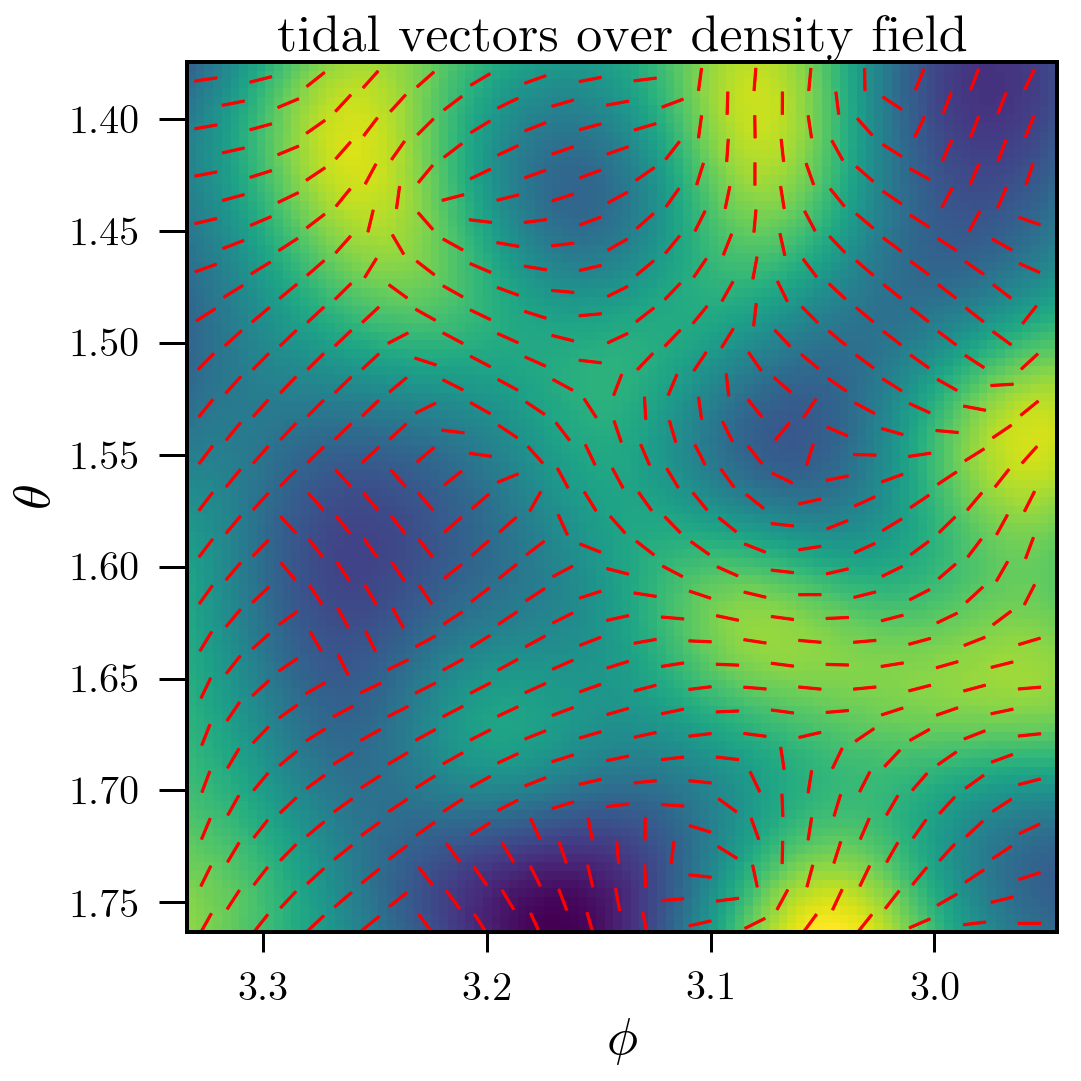

In [10]:
fig = plt.figure(figsize=(8,8))


plt.imshow(smoothed_cutout.T,
          extent=( np.min(ph_), np.max(ph_), np.max(th_), np.min(th_)) )
plt.xlim( np.max(ph_), np.min(ph_) )

plt.xlabel(r"$\phi$")
plt.ylabel(r"$\theta$")


width=np.pi / 8
height=np.pi / 8
center_phi=np.pi
center_theta=np.pi/2
        
        
# now add in the vector field of the principal vectors
for i in range(npix):
    th0, ph0 = th[i], ph[i]
    if ((ph0 > center_phi - width/2) & (ph0 < center_phi + width/2) & \
        (th0 > center_theta - height/2) & (th0 < center_theta + height/2)):
        # plot vector
        scaling = 100
        
        vec = principal_eigenvectors[i,:] 
        dx, dy = vec[0] / scaling, vec[1] / scaling
        plt.arrow( ph0 - dx/2, th0 - dy/2, dx, dy, lw=0.5, head_width=0, color="r" )
        
        
plt.title("tidal vectors over density field")
plt.plot([],[],"r-", label="t12 correction")
# plt.legend(loc=(1.1,0.9))

fig.savefig('../figures/tidal.png', transparent=False)

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


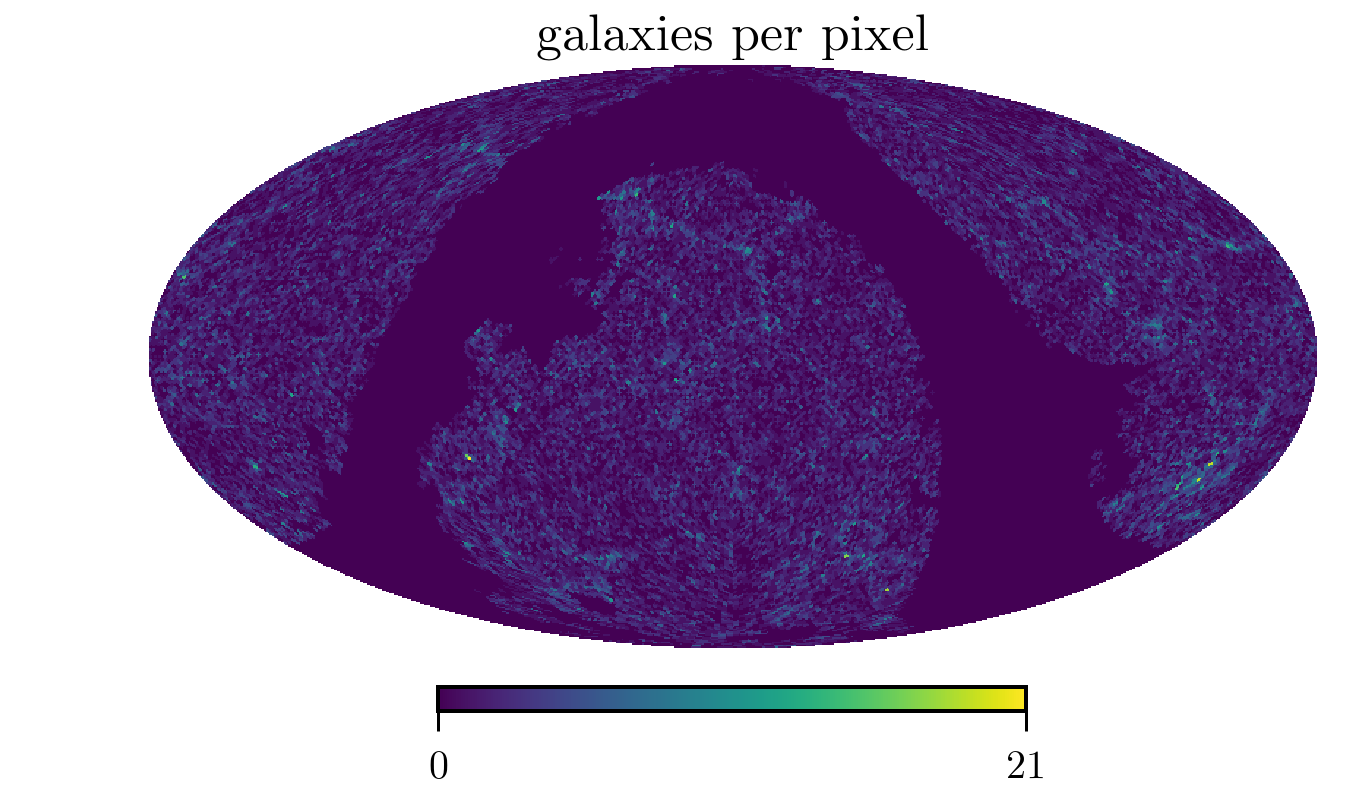

In [96]:
# check we are getting density right
counts_per_pixel = np.zeros(npix)
np.add.at(counts_per_pixel, hp_gal, 1)
hp.mollview(counts_per_pixel, title='galaxies per pixel')

binned_phi_x = np.zeros(npix)
binned_phi_y = np.zeros(npix)
np.add.at(binned_phi_x, hp_gal, phi_x)
np.add.at(binned_phi_y, hp_gal, phi_y)

binned_phi_x /= counts_per_pixel
binned_phi_y /= counts_per_pixel
binned_phi_x[ mask == 0.0 ] = 0
binned_phi_y[ mask == 0.0 ] = 0

# hp.mollview(binned_phi_x, title='phix')
# hp.mollview(binned_phi_y, title='phiy')

# By Pixel

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zequnl/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


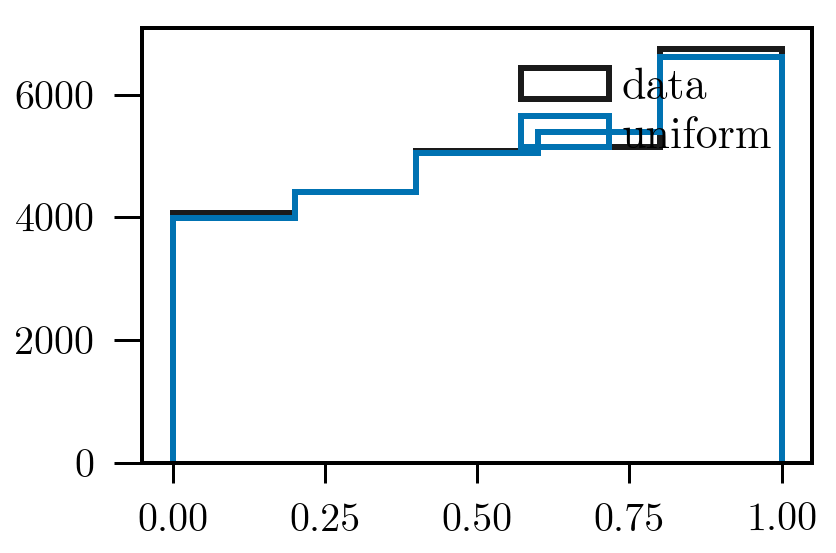

In [12]:
pix_dot = np.abs(binned_phi_x * principal_eigenvectors[:,0] + \
    binned_phi_y * principal_eigenvectors[:,1])

rand_theta = np.random.rand(len(galaxy_data)) * np.pi
rand_x = np.cos(rand_theta)
rand_y = (np.sin(rand_theta))

# check we are getting density right
binned_phi_x_random = np.zeros(npix)
binned_phi_y_random = np.zeros(npix)
np.add.at(binned_phi_x_random, hp_gal, rand_x)
np.add.at(binned_phi_y_random, hp_gal, rand_y)

binned_phi_x_random /= counts_per_pixel
binned_phi_y_random /= counts_per_pixel

rand_dot = np.abs(binned_phi_x_random * principal_eigenvectors[:,0] + \
    binned_phi_y_random * principal_eigenvectors[:,1])

plt.hist(pix_dot[mask > 0.0], bins=5, histtype="step", label="data")
plt.hist(rand_dot[mask > 0.0], bins=5, histtype="step", label="uniform")

plt.legend()

In [13]:

# plt.hist(rand_dot[mask > 0.0], bins=30, histtype="step", label="uniform", normed=True)
# xx = np.linspace(0,1.0)
# plt.plot( xx, 2 / np.sqrt(1 - xx**2) / np.pi )

In [14]:
# pix_dot = np.abs(binned_phi_x * principal_eigenvectors[:,0] + \
#     binned_phi_y * principal_eigenvectors[:,1])

# rand_theta = np.random.rand(npix) * 2 * np.pi
# rand_x = np.cos(rand_theta)
# rand_y = (np.sin(rand_theta))
# rand_dot = np.abs(rand_x * principal_eigenvectors[:,0] + \
#     rand_y * principal_eigenvectors[:,1])

# plt.hist(pix_dot[mask > 0.0], bins=30, histtype="step", label="data")
# plt.hist(rand_dot[mask > 0.0], bins=30, histtype="step", label="uniform")

# plt.legend()

# By Galaxies, 1 realization

In [15]:
rand_binned = []

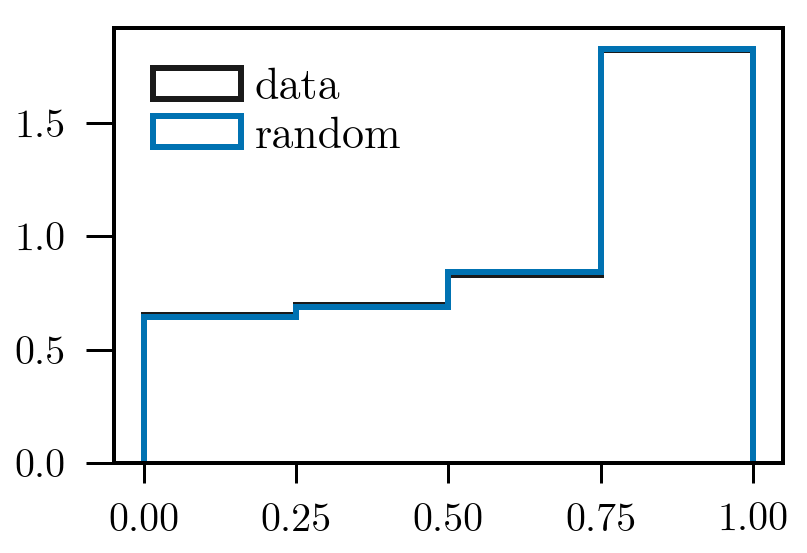

In [93]:
ngal = len(galaxy_data)
rand_theta = np.random.rand( ngal ) * 180 - 90 # all ellipticities have y > 0
rand_phi_x = -np.cos((90-rand_theta) * np.pi / 180)
rand_phi_y = np.sin((90-rand_theta) * np.pi / 180)

galaxy_tidal_x = principal_eigenvectors[hp_gal,0]
galaxy_tidal_y = principal_eigenvectors[hp_gal,1]
galaxy_tidal_lam = principal_eigenvalues[hp_gal]

abs_dot = np.abs(galaxy_tidal_x * phi_x + galaxy_tidal_y * phi_y)
rand_dot = np.abs(galaxy_tidal_x * rand_phi_x + galaxy_tidal_y * rand_phi_y)
# plt.hist( abs_dot );
countsg, bins, _ = plt.hist( abs_dot, bins=4, histtype="step", label="data", density=True, range=(0,1) );
countsr, bins, _ = plt.hist( rand_dot, bins=4, histtype="step", label="random", density=True, range=(0,1) );
plt.legend(loc="upper left")

(0, 1.0)

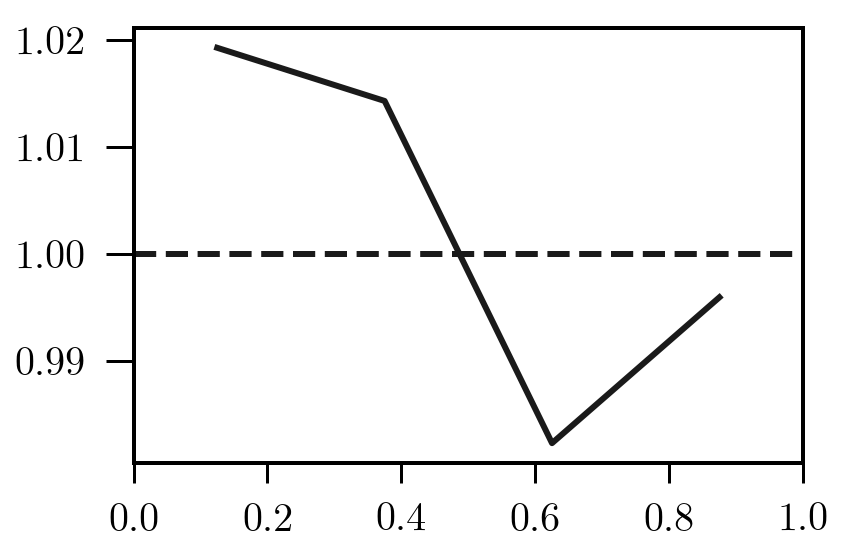

In [94]:
bin_midpoints = (bins[1:] + bins[:-1])/2
plt.plot( bin_midpoints, countsg / countsr )
plt.axhline(1.0, ls="dashed")
plt.xlim(0,1.0)

# statistics

We define a really dumb test statistic, the sum of all absolute values of dot products over all galaxies.

$$ T = \sum_g | \vec{v}_g \cdot \vec{t}(x_g) |$$

We then compute the 1D distribution of this test statistic by randomly spinning and generating realizations.

In [65]:
def generate_realization():
    ngal = len(galaxy_data)
    rand_theta = np.random.rand( ngal ) * 180 - 90 # all ellipticities have y > 0
    rand_phi_x = -np.cos((90-rand_theta) * np.pi / 180)
    rand_phi_y = np.sin((90-rand_theta) * np.pi / 180)
    rand_dot = np.abs(galaxy_tidal_x * rand_phi_x + galaxy_tidal_y * rand_phi_y)
    return rand_dot

In [66]:
abs_dot = np.abs(galaxy_tidal_x * phi_x + galaxy_tidal_y * phi_y)
abs_sum = np.mean(abs_dot)

In [86]:
nrealizations = 20000
realizations = np.array( [generate_realization() for i in range(nrealizations)] )

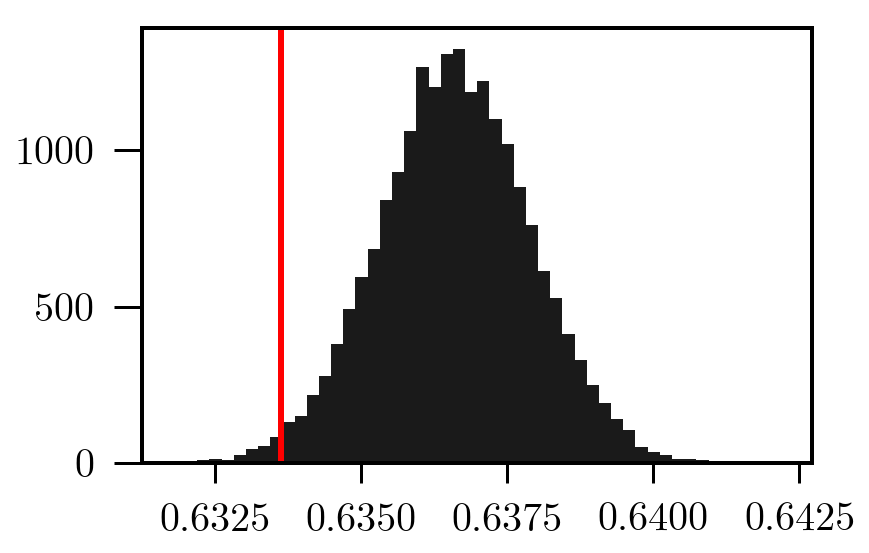

In [87]:
plt.hist( np.mean(realizations, axis=1), bins=50);
plt.axvline(abs_sum, color="red")

# binning
Now let's bin and take ratios with the random one.

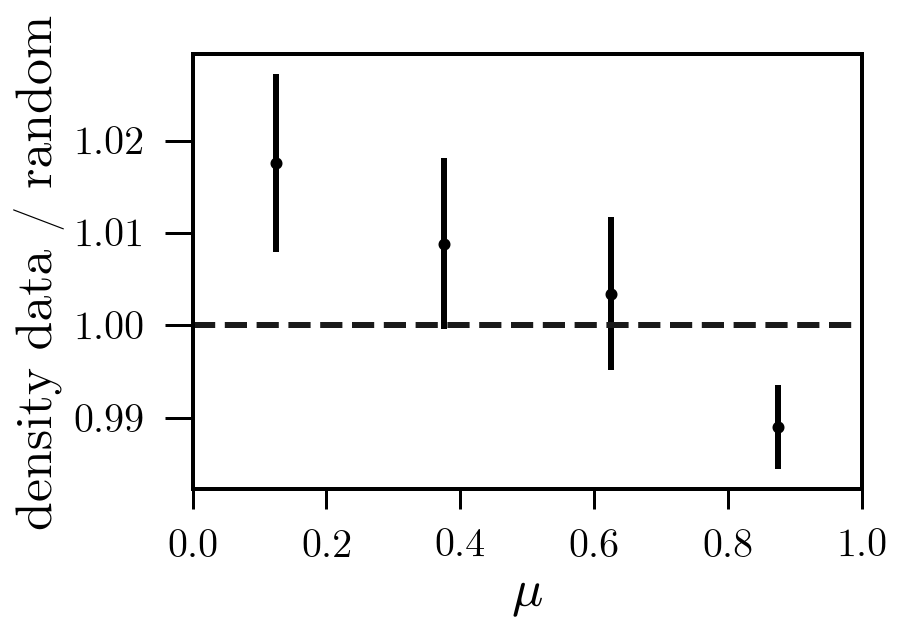

In [90]:
nbins = 4
counts_arr = np.zeros((nrealizations, nbins))

for i in range(nrealizations):
    countsr, bins = np.histogram( realizations[i,:], range=(0,1),
                                bins=nbins, density=True );
    counts_arr[i,:] = countsr
    
means =  np.mean( counts_arr, axis=0 )
abs_dot = np.abs(galaxy_tidal_x * phi_x + galaxy_tidal_y * phi_y)
countsg, bins = np.histogram( abs_dot, bins=nbins, density=True, range=(0,1) );

bin_midpoints = (bins[1:] + bins[:-1])/2
plt.errorbar( bin_midpoints,  countsg / means,
            yerr=np.std( counts_arr, axis=0 ) / means, fmt='ko')
plt.xlim(0,1)
plt.xlabel(r"$\mu$")
plt.ylabel(r"density data / random")
plt.axhline(1.0, ls="dashed")

changing the number of bins makes it worse though...

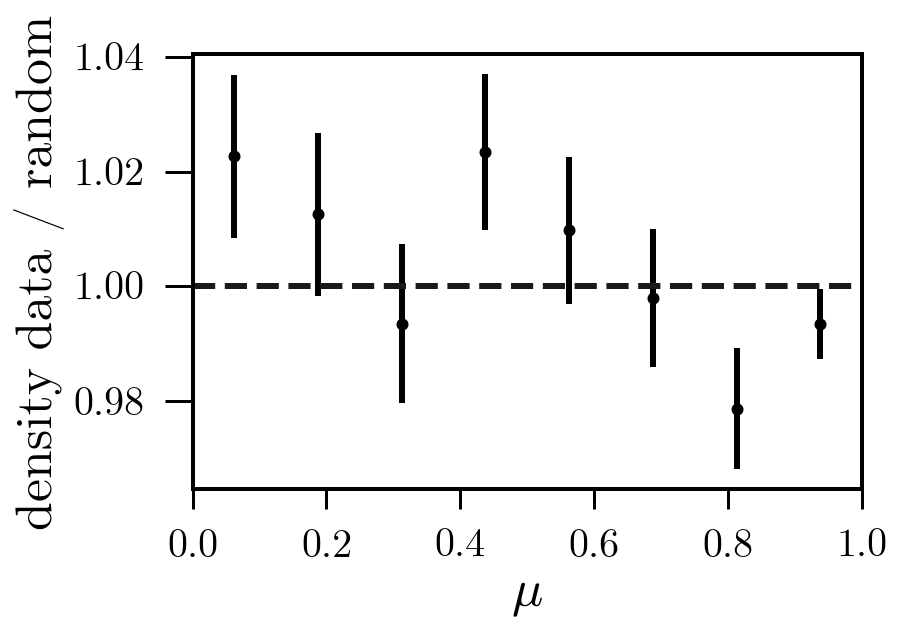

In [92]:
nbins = 8
counts_arr = np.zeros((nrealizations, nbins))

for i in range(nrealizations):
    countsr, bins = np.histogram( realizations[i,:], range=(0,1),
                                bins=nbins, density=True );
    counts_arr[i,:] = countsr
    
means =  np.mean( counts_arr, axis=0 )
abs_dot = np.abs(galaxy_tidal_x * phi_x + galaxy_tidal_y * phi_y)
countsg, bins = np.histogram( abs_dot, bins=nbins, density=True, range=(0,1) );

bin_midpoints = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_midpoints,  countsg / means,
             yerr=np.std( counts_arr, axis=0 )  / means,
             fmt='ko')
plt.xlim(0,1)
plt.xlabel(r"$\mu$")
plt.ylabel(r"density data / random")
plt.axhline(1.0, ls="dashed")